In [20]:
import os
#print(os.getcwd())
import sys
sys.path.append('..') # examples
sys.path.append('../..') # PINNFramework etc.
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

 18%|█▊        | 18207/100000 [01:40<07:21, 185.45it/s]

In [2]:
from PINNFramework.PINN import Interface
from PINNFramework.models.mlp import MLP

In [3]:
from torch.autograd import grad
import torch
import numpy as np
import torch.nn as nn
import scipy.io
from pyDOE import lhs
import torch.optim as optim

In [4]:
class Poisson1DPINN(Interface):
    def __init__(self, model, input_d = 1, output_d = 1, lb = [0], ub = [1], C = 1):
        super().__init__(model,input_d,output_d)
        self.lb = lb
        self.ub = ub
        self.C = C


    def derivatives(self, u, x):
        grads= torch.ones(x.shape[0])
        pred_u = u[:,0]
        J_u = grad(pred_u, x, create_graph=True, grad_outputs=grads)[0]
        
        #calculate first order derivatives
        u_x = J_u[:,0]

        pred_derivatives = torch.stack([u_x],1)
        return pred_derivatives
    
    
    def pde(self, x, u, derivatives):
        u_x = derivatives[:,0]
        _u = u[:,0]
        pde_residual = u_x + self.C**2 * _u #Du - g(x)
        return pde_residual
  
    
    
    def initial_loss(self, x, u0):
        """
        Supervised loss for training the initial condition 
        """
        x = x.view(-1)

        UV = self.forward(x)
        u = UV[:, 0]

        u0 = u0.view(-1)


        return torch.mean((u0 - u) ** 2)
    
    
    def input_normalization(self,x):
        """
        Implementation of min-max scaling in range of [-1,1]
        """
        xx = 2.0 * (x - self.lb) / (self.ub - self.lb) - 1.0
        return xx

In [5]:

# Poisson equation
g = lambda x, C : np.sin(C*x)
h = lambda x, C : -C**2 * g(x,C)
C = 1

In [6]:
# bounds
lb = torch.tensor([0.0])
ub = torch.tensor([1.0])

# boundary conditions at x=0 and x=1
coord_bc = [0, 1]
data_bc = [h(0,1), h(1,1)]

# residual points
x_f = np.random.uniform(0,1, size = 100)

In [7]:
pinn_model = MLP(input_size=1, output_size=1, num_hidden=3, hidden_size=100)

pinn_model = nn.Sequential(
          nn.Linear(1,100),
          nn.Tanh(),
          nn.Linear(100,100),
          nn.Tanh(),
          nn.Linear(100,100),
          nn.Tanh(),
          nn.Linear(100,100),
          nn.Tanh(),
          nn.Linear(100,1)
        )

In [8]:
model = Poisson1DPINN(model = pinn_model, ub=ub, lb = lb)

In [9]:
x = {"x_0": torch.tensor(coord_bc).float().view(-1,1), "x_f":torch.tensor(x_f).float().view(-1,1), "x_b": torch.tensor(coord_bc).float().view(-1,1)}
data_ub = torch.tensor(data_bc).float().view(-1,1)

In [10]:
optimizer = optim.Adam(model.parameters(),lr=1e-5)

In [25]:
pbar = tqdm()
num_epochs = 100000
pbar.reset(total=num_epochs)
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = model.pinn_loss(x, data_ub, data_ub ,interpolation_criterion=nn.MSELoss(), boundary_criterion=nn.MSELoss(), pde_norm=nn.MSELoss())
    loss.backward()
    optimizer.step()
    pbar.set_description("Loss %10f" % loss.item())
    pbar.update()
pbar.refresh()

KeyboardInterrupt: 

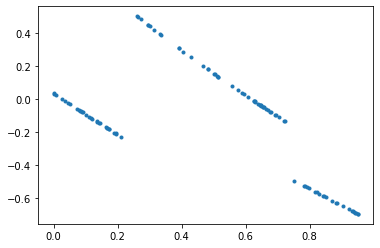

In [28]:
with torch.no_grad():
    y_hat = model(torch.tensor(x_f).float().view(-1,1))
    
plt.plot(x_f,y_hat.cpu().numpy(),'.')